# GAN model for Monet style painting

This project is related to the Keggle competition "I’m Something of a Painter Myself". All information about the dataset and the competition can be found here: https://www.kaggle.com/competitions/gan-getting-started/overview.

The objective is to build a GAN (Generative Adversarial Networks) model that generates 7,000 to 10,000 Monet-style images.

The data contains 300 Monet paintings sized 256x256 in TFRecord format.



Credit to the starter code: https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook for the orginal CyclGan model

In [1]:
%pip install tensorflow_addons
#%pip install keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.7 MB/s eta 0:00:00a 0:00:01m
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.1.5
    Uninstalling typeguard-4.1.5:
      Successfully uninstalled typeguard-4.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.4 requires typeguard<5,>=4.1.2, but you have typeguard 2.13.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


Importing the libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

from functools import partial
from albumentations import (Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip, Rotate)

AUTOTUNE = tf.data.experimental.AUTOTUNE

2024-02-19 13:34:35.163611: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 13:34:35.163724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 13:34:35.334916: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our Tens

Check TPU:

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


------------
EDA and data cleaning
---------------

Loading the tfrec data:

In [4]:
GCS_PATH = KaggleDatasets().get_gcs_path()
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [5]:
IMAGE_SIZE = [256, 256]

Function ot normalize the pictures an scale them to [-1, 1]:

In [6]:
def normalize(image):
    return (tf.cast(image, tf.float32) / 127.5) - 1

function to decode the picture:

In [7]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

functions for data agumentation: adding random jitter

In [8]:
def random_crop(image):
    cropped_image = tf.image.random_crop(image, size=[256, 256, 3])
    return cropped_image

def random_jitter(image):
    # resizing to 286 x 286 x 3 
    image = tf.image.resize(image, [int(256*1.3), int(256*1.3)],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # randomly cropping to 256 x 256 x 3
    image = random_crop(image)
    # random mirroring
    return image

def preprocess_image_train(image, label=None):
    image = random_jitter(image)
    return image

Function to read the tfrec files (using the decode function)

In [9]:
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

Function to load the dataset (using previous functions):

In [10]:
def load_dataset(filenames, labeled=False, ordered=False, repeats=200):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    dataset = dataset.concatenate(dataset.map(random_jitter, num_parallel_calls=AUTOTUNE).shuffle(10000, reshuffle_each_iteration=True).repeat(repeats))
    dataset = dataset.map(normalize, num_parallel_calls=AUTOTUNE).shuffle(10000)
    return dataset

Function to view images:

In [11]:
def view_image(ds, rows=1):
    image = next(iter(ds))
    image = image.numpy()

    fig = plt.figure(figsize=(22, rows * 5.05 ))
    for i in range(5 * rows):
        ax = fig.add_subplot(rows, 5, i+1, xticks=[], yticks=[])
        ax.imshow(image[i] / 2 + .5)


Loading monet dataset and photo dataset with batcxh size of 50:

In [12]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True, repeats=1).batch(50, drop_remainder=True)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True, repeats=1).batch(50, drop_remainder=True)

Some exmaples of the Monet pictures

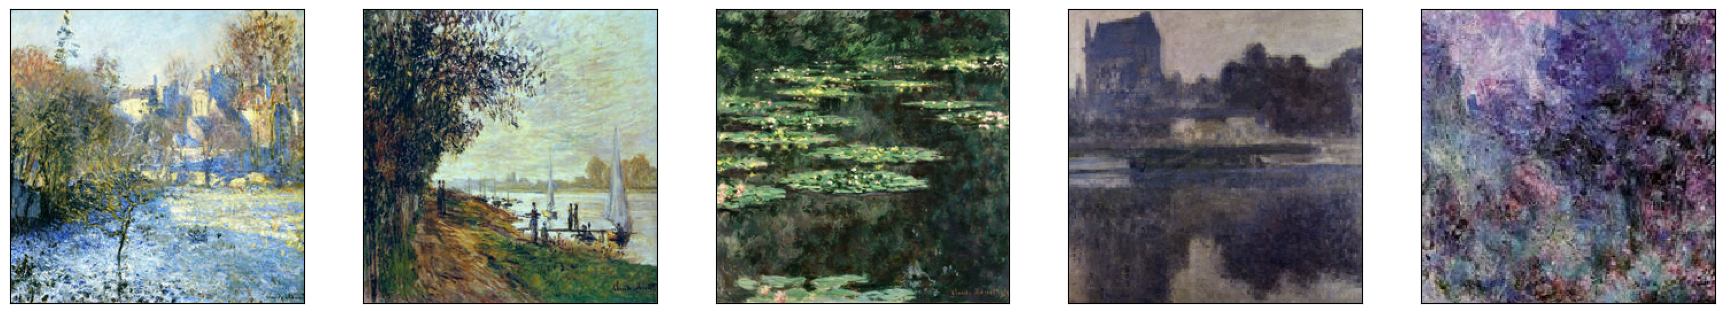

In [13]:
view_image(monet_ds)

Some examples of Normal photos

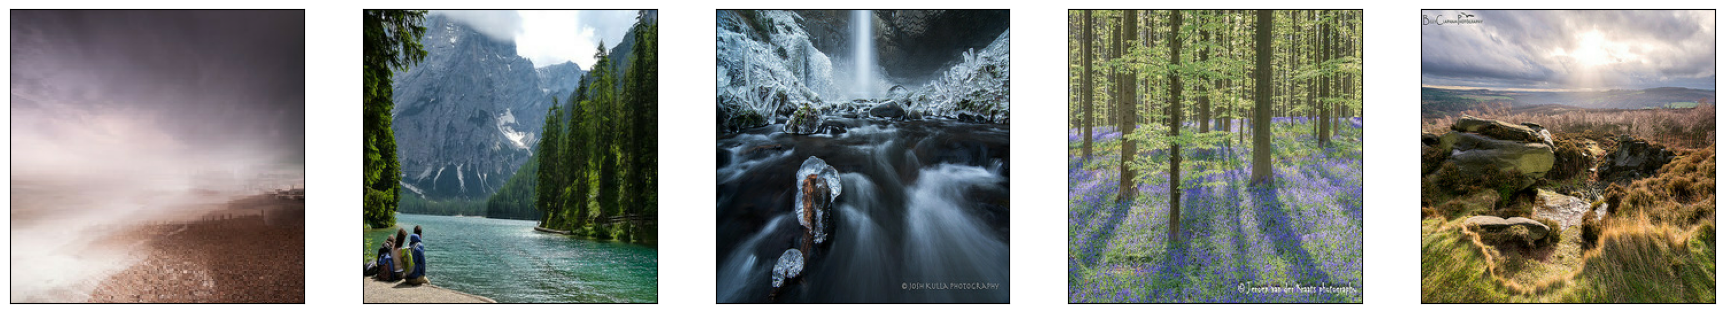

In [14]:
view_image(photo_ds)

---------------
DCGAN Model
-------------

Function to generate layers for encoding by reducing the image dimensions using Conv2D, MaxPool and LeakyReLU activation function: 

In [15]:
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, padding='same', kernel_initializer=initializer, use_bias=False))
    result.add(layers.MaxPool2D())

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

Function to generate layers for decoding by increasing the image dimensions using Conv2DTranspose (stride=2) and LeakyReLU activation function and dropout=0.5: 

In [16]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,padding='same', kernel_initializer=initializer, use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.LeakyReLU())

    return result

Function for encoding and decoding for the images for the generator using skip connectors to avoid vanishing gradients:


In [17]:
def CycleGenerator():
    inputs = layers.Input(shape=[256,256,3])

    down_stack = [
        downsample(16, 4, apply_instancenorm=False), 
        downsample(32, 4), 
        downsample(64, 4), 
        downsample(128, 4), 
        downsample(128, 4), 
        downsample(128, 4),

    ]

    up_stack = [
#         upsample(128, 4, apply_dropout=True), 
        upsample(128, 4, apply_dropout=True), 
        upsample(128, 4, apply_dropout=True), 
        upsample(128, 4, apply_dropout=True), 
        upsample(64, 4, apply_dropout=True), 
        upsample(32, 4), 
        upsample(16, 4), 
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

Function for the discriminator only with 3 layers of downsample, 2 layers of Conv2D and 1 dense layer

In [18]:
def CycleDiscriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(16, 4, False)(x) 
    down2 = downsample(32, 4)(down1) 
    down3 = downsample(64, 4)(down2) 

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(128, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1) 

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) 
    last_conv = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) 

    last_relu = layers.LeakyReLU(alpha=0.2)(last_conv)
    last_pool = layers.Flatten()(last_relu)
    last = layers.Dense(1, activation='sigmoid')(last_pool)

    return tf.keras.Model(inputs=inp, outputs=last)

In [19]:
OUTPUT_CHANNELS = 3
LATENT_DIM = 256

with strategy.scope():
    monet_cycle_generator = CycleGenerator() # transforms photos to Monet-esque paintings
    photo_cycle_generator = CycleGenerator() # transforms Monet paintings to be more like photos

    monet_cycle_discriminator = CycleDiscriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_cycle_discriminator = CycleDiscriminator() # differentiates real photos and generated photos

class (subclass of keras.model) for cycling the GAN (photo to Monet like photo and reverse):

In [20]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
        real_label=.5
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        self.real_label = real_label
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        batch_size = tf.shape(real_photo)[0]
        labels_real = tf.zeros((batch_size, 1)) + self.real_label
        labels_real += 0.05 * tf.random.uniform(tf.shape(labels_real))        
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_real_monet, disc_fake_monet, labels_real)
            photo_gen_loss = self.gen_loss_fn(disc_real_photo, disc_fake_photo, labels_real)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet, labels_real)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo, labels_real)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

Defining losses for generator and discriminator and overall loss

In [21]:
EPOCHS = 10

LR_G = 2e-4
LR_D = 2e-4
beta_1 = .5

real_label = .9
fake_label = 0


with strategy.scope():
    def discriminator_loss(predictions_real, predictions_gen, labels_real):
        return (tf.reduce_mean((predictions_gen  - tf.reduce_mean(predictions_real) + labels_real) ** 2) +
                tf.reduce_mean((predictions_real - tf.reduce_mean(predictions_gen)  - labels_real) ** 2))/2
    
    def generator_loss(predictions_real, predictions_gen, labels_real):
        return (tf.reduce_mean((predictions_real - tf.reduce_mean(predictions_gen)  + labels_real) ** 2) +
                tf.reduce_mean((predictions_gen  - tf.reduce_mean(predictions_real) - labels_real) ** 2)) / 2
    
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1
    
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

Optimizer for generator and discriminator: Adam with learning rates defined above

In [22]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(LR_G, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(LR_G, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(LR_D, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(LR_D, beta_1=0.5)
    

instantce of the subclass and compiling the model with the optimizer and loss functions defined above:

In [23]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_cycle_generator, photo_cycle_generator, monet_cycle_discriminator, photo_cycle_discriminator, real_label=0.66
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )
    

In [24]:
cycle_gan_model.fit(tf.data.Dataset.zip((monet_ds, photo_ds)),epochs=EPOCHS)

Epoch 1/10


2024-02-19 13:35:43.566770: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_6/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1708349784.478582     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12/12 [==============================] - 100s 2s/step - monet_gen_loss: 11.3032 - photo_gen_loss: 11.7724 - monet_disc_loss: 0.4623 - photo_disc_loss: 0.4701
Epoch 2/10
12/12 [==============================] - 46s 2s/step - monet_gen_loss: 11.1370 - photo_gen_loss: 11.4561 - monet_disc_loss: 0.3829 - photo_disc_loss: 0.4485
Epoch 3/10
12/12 [==============================] - 47s 2s/step - monet_gen_loss: 10.5014 - photo_gen_loss: 10.7527 - monet_disc_loss: 0.2696 - photo_disc_loss: 0.3251
Epoch 4/10
12/12 [==============================] - 45s 2s/step - monet_gen_loss: 9.2653 - photo_gen_loss: 9.7103 - monet_disc_loss: 0.1872 - photo_disc_loss: 0.1470
Epoch 5/10
12/12 [==============================] - 46s 2s/step - monet_gen_loss: 7.4215 - photo_gen_loss: 7.6783 - monet_disc_loss: 0.1320 - photo_disc_loss: 0.1714
Epoch 6/10
12/12 [==============================] - 47s 2s/step - monet_gen_loss: 6.2021 - photo_gen_loss: 6.2214 - monet_disc_loss: 0.1391 - photo_disc_loss: 0.2367
Epoch 7/

---------
Results
-----------

Below some results comparing the original image and the respective "Monet-like" image

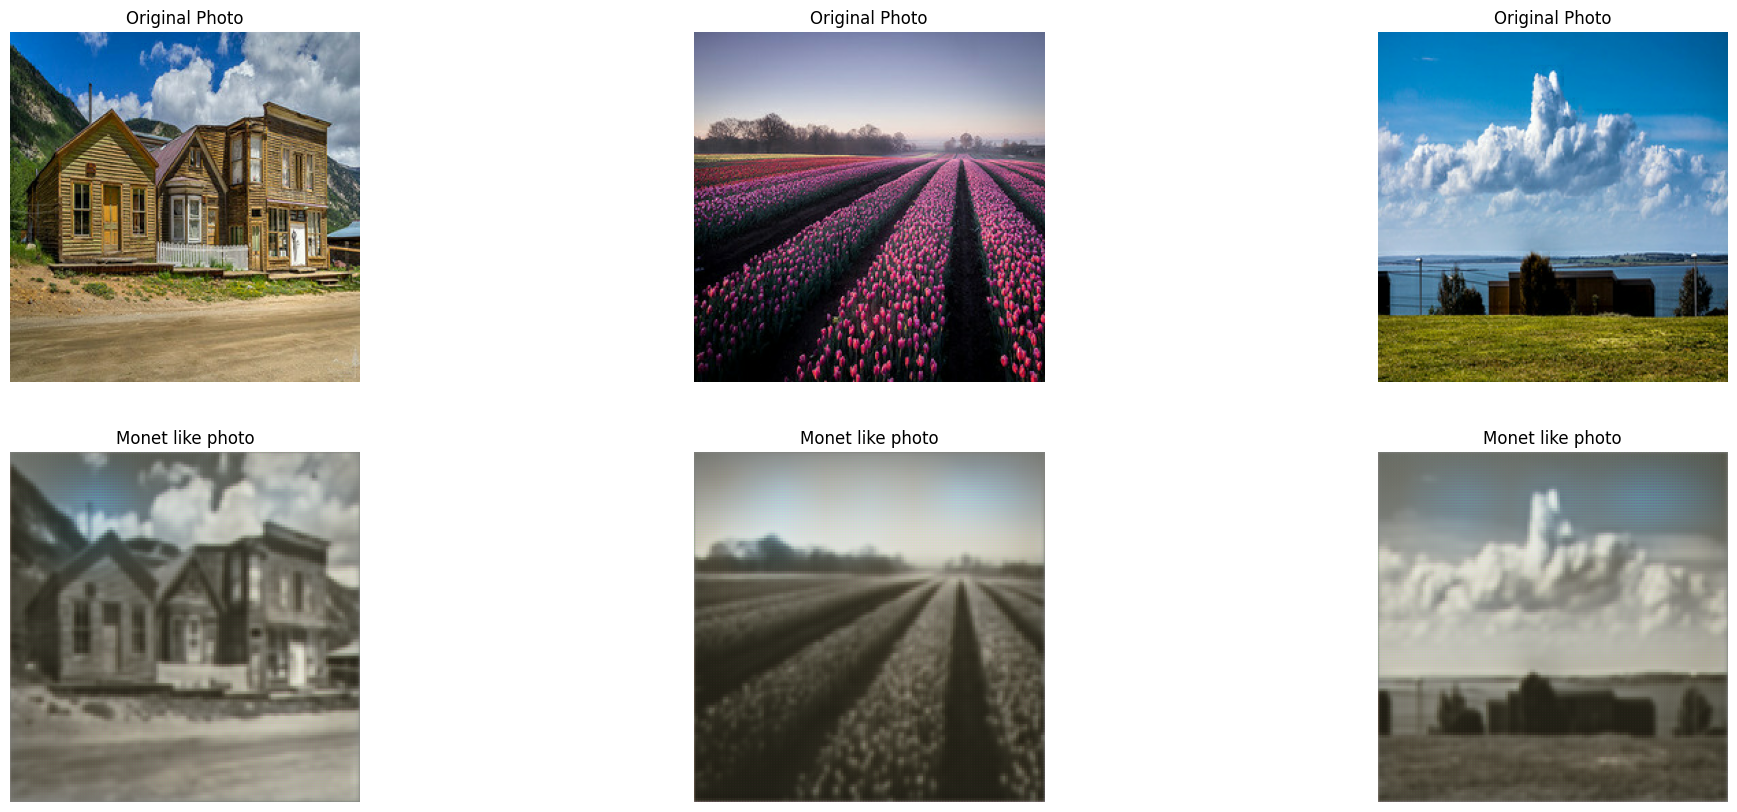

In [25]:
_, ax = plt.subplots(2, 3, figsize=(25, 10))
for i, img in enumerate(photo_ds.take(3)):
    prediction = monet_cycle_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[0, i].imshow(img)
    ax[1, i].imshow(prediction)
    ax[0, i].set_title("Original Photo")
    ax[1, i].set_title("Monet like photo")
    ax[0, i].axis("off")
    ax[1, i].axis("off")
plt.show()

----------------
Prediction and submission
--------------

In [26]:
import PIL
! mkdir ../images

In [27]:
photo_ds_full = load_dataset(PHOTO_FILENAMES, labeled=True, repeats=1).batch(1)

In [28]:
for i, img in enumerate(photo_ds_full.take(7000)):
    prediction = monet_cycle_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")

In [29]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

-----------
Conclusion
----------

Below is the result of the submission to Kaggle: 
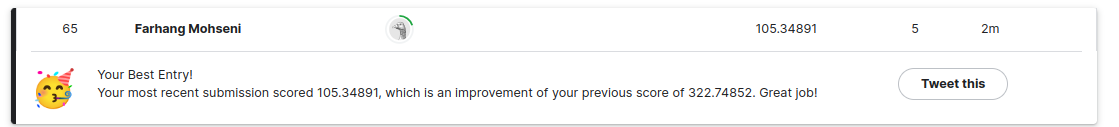


To improve the model one can:
- incease the model capacity (especially for the generator model) by adding more layers and increase the layer size
- run for longer epochs
- perform hyperparameter tuning on model architecture, learning rate, optimizer type, ...
- improve the data agumentation by adding fliping, rotation, ...